# EDA (Exploration Data Analysis)

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive')

  PATH_DRIVER = '/content/gdrive/My Drive/'
  DATA_FOLDER = 'AI Dataset Sample/'

  !pip install fastai pydicom kornia --upgrade --quiet
  
  from getpass import getpass
  user = getpass('GitHub user')
  password = getpass('GitHub password')
  os.environ['GITHUB_AUTH'] = user + ':' + password
  !git clone https://$GITHUB_AUTH@github.com/lluissalord/radiology_ai.git

  %cd radiology_ai

  IN_COLAB = True
except:
  PATH_DRIVER = ''
  DATA_FOLDER = 'data/'
  IN_COLAB = False

import pydicom

from fastai.basics import *
from fastai.medical.imaging import *

In [3]:
PATH_PREFIX = os.path.join(PATH_DRIVER, DATA_FOLDER, '')
raw_folder = PATH_PREFIX + 'raw'
organize_folder = PATH_PREFIX + 'organized'
preprocess_folder = PATH_PREFIX + 'preprocess'


Filename.........: data/organized/CD/0/01010000265254.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.1

Patient's name....: 01010000265254, 
Patient id........: 01010000265254
SeriesDescription.: RODILLA AP
Body Part Examined: LOWER LIMB
Modality..........: CR
Study Date........: 20190117
Image size.......: 2010 x 1195, 4803900 bytes
Pixel spacing....: None
Slice location...: (missing)


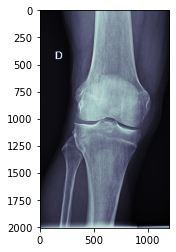

In [4]:
filename = raw_folder + '/01010000265254/ARIN1J7K5QQ7BeDIUIAP8PM4NVSG41D1DU1S970T5PVP84VGN999B'
filename = organize_folder + '/CD/0/01010000265254.dcm'
dcm = dcmread(filename)

# Normal mode:
print()
print("Filename.........:", filename)
print("Storage type.....:", dcm.SOPClassUID)
print()

pat_name = dcm.PatientName
display_name = pat_name.family_name + ", " + pat_name.given_name
print("Patient's name....:", display_name)
print("Patient id........:", dcm.PatientID)
print("SeriesDescription.:", dcm.SeriesDescription)
print("Body Part Examined:", dcm.BodyPartExamined)
print("Modality..........:", dcm.Modality)
print("Study Date........:", dcm.StudyDate)

if 'PixelData' in dcm:
    rows = int(dcm.Rows)
    cols = int(dcm.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dcm.PixelData)))
    if 'PixelSpacing' in dcm:
        print("Pixel spacing....:", dcm.PixelSpacing)

# use .get() if not sure the item exists, and want a default value if missing
print("Slice location...:", dcm.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.imshow(dcm.pixel_array, cmap=plt.cm.bone)
plt.show()

## Raw Data EDA

In [5]:
df = pd.DataFrame.from_dicoms(
    get_files(raw_folder)
)
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
SpecificCharacterSet,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100
ImageType,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED
SOPClassUID,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1
SOPInstanceUID,1216.1158.1243.113.1196.184.20190117113311.12,1216.1158.1243.113.1196.184.20190117113311.11,1216.1158.1243.113.1196.184.20190129103613.4,1216.1158.1243.113.1196.184.20190129103613.3,1216.1158.1243.113.1196.184.20190130113155.3,1216.1158.1243.113.1196.184.20190130113155.4,1216.1158.1243.113.1196.184.20190215174436.39,1216.1158.1243.113.1196.184.20190215174436.40,1216.1158.1243.113.1196.184.20190220113109.4,1216.1158.1243.113.1196.184.20190220113109.3,1216.1158.1243.113.1196.184.20190226200138.32,1216.1158.1243.113.1196.184.20190226200138.31,1216.1158.1243.113.1196.184.20190304113146.3,1216.1158.1243.113.1196.184.20190304113147.4,1216.1158.1243.113.1196.184.20190305135429.11,1216.1158.1243.113.1196.184.20190305135429.12,1216.1158.1243.113.1196.184.20190314154700.12,1216.1158.1243.113.1196.184.20190314154700.11,1216.1158.1243.113.1196.184.20190326143920.13,1216.1158.1243.113.1196.184.20190326143920.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
img_min,229,88,257,88,124,160,136,189,41,143,206,129,141,332,204,149,174,82,108,205
img_max,4045,4051,3992,4046,4047,4039,4039,4048,4077,4074,4057,4034,4002,4044,4028,4052,4054,4054,4044,3989
img_mean,1572.4,1313.57,1659.04,1333.04,1209.44,1500.65,1524.69,1797.34,1554.25,1383.55,1820.87,1575.75,1412.97,1585.08,1136.37,1587,1746.54,1427.68,1445.9,1778.77
img_std,854.028,925.985,862.923,969.833,905.58,821.823,959.375,850.451,998.594,947.756,866.827,956.061,869.146,800.869,826.035,910.212,896.368,966.333,959.274,843.377


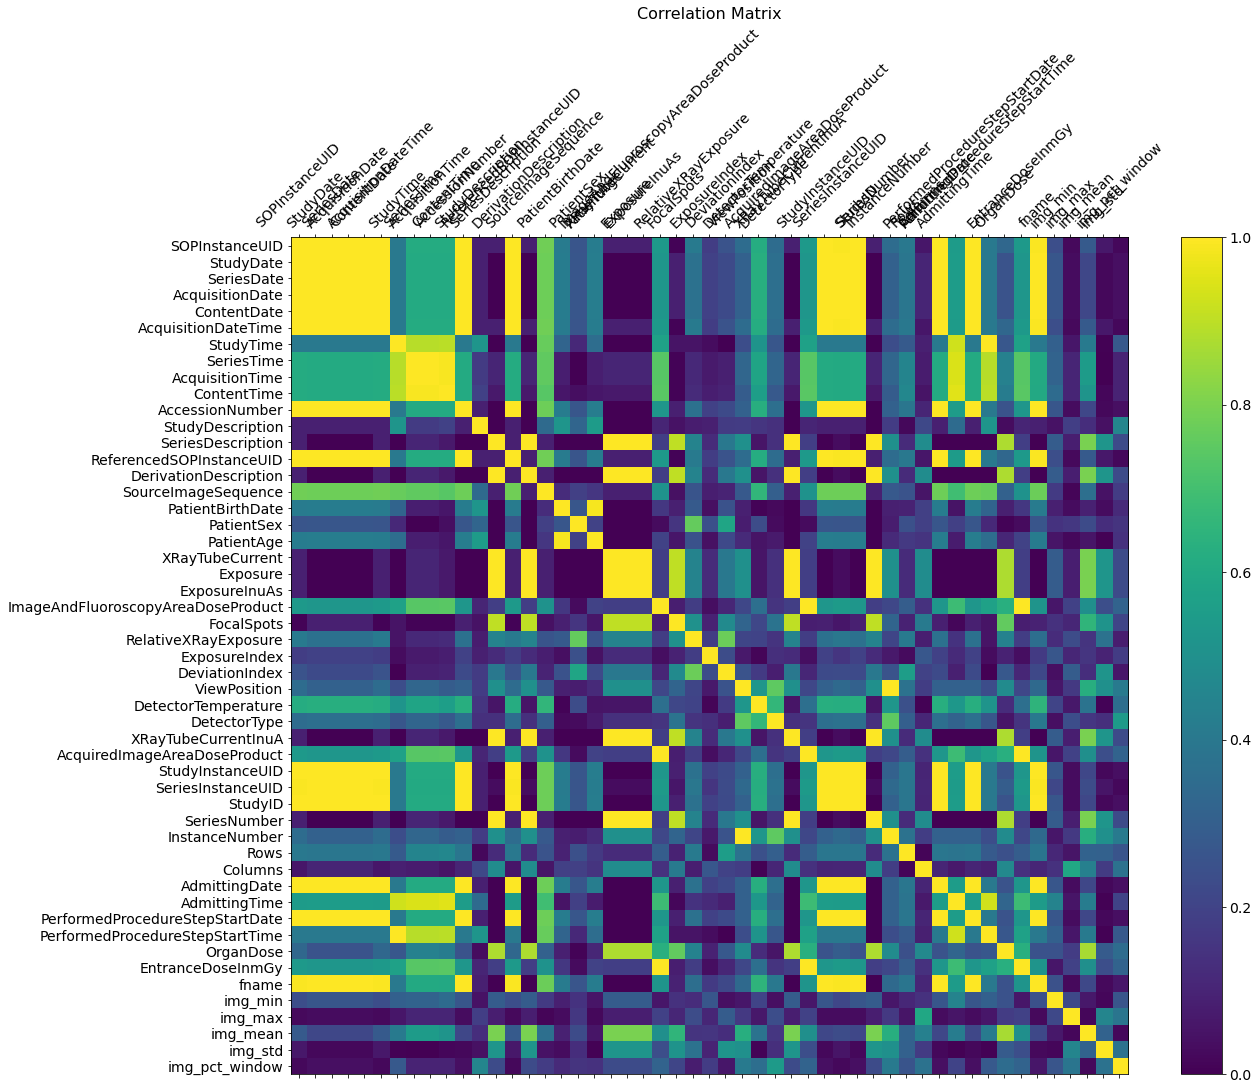

In [7]:
corr = df.astype('string').astype('category').apply(lambda x: x.cat.codes, axis=0).corr()

corr = corr.loc[corr.notnull().any(axis=0),corr.notnull().any(axis=1)].abs()

f = plt.figure(figsize=(19, 15))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(corr.shape[1]), corr.columns, fontsize=14, rotation=45)
plt.yticks(range(corr.shape[1]), corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.show()

In [6]:
repr_flds = [
    'SeriesDescription',
    'BodyPartExamined',
    'Modality',
    'StudyDescription',
    # 'ViewPosition',
    # 'AcquiredImageAreaDoseProduct'
]
display(df.pivot_table(values=['img_mean','img_std','img_max','img_min','PatientID'], index=repr_flds,
                   aggfunc={'img_mean':'mean','img_max':'max','img_min':'min', 'img_std':'mean','PatientID':'count'}))

PatientID  \
SeriesDescription BodyPartExamined Modality StudyDescription                           
RODILLA AP        LOWER LIMB       CR       Rodilla AP y LAT  : Derecho            8   
                                            Rodilla AP y LAT  : Izquierdo          2   
RODILLA LAT       LOWER LIMB       CR       Rodilla AP y LAT  : Derecho            8   
                                            Rodilla AP y LAT  : Izquierdo          2   

                                                                           img_max  \
SeriesDescription BodyPartExamined Modality StudyDescription                         
RODILLA AP        LOWER LIMB       CR       Rodilla AP y LAT  : Derecho       4054   
                                            Rodilla AP y LAT  : Izquierdo     4074   
RODILLA LAT       LOWER LIMB       CR       Rodilla AP y LAT  : Derecho       4057   
                                            Rodilla AP y LAT  : Izquierdo     4077   

                                                                              img_mean  \
SeriesDescription BodyPartExamined Modality StudyDescription                             
RODILLA AP        LOWER LIMB       CR       Rodilla AP y LAT  : Derecho    1370.805098   
                                            Rodilla AP y LAT  : Izquierdo  1398.260264   
RODILLA LAT       LOWER LIMB       CR       Rodilla AP y LAT  : Derecho    1682.826535   
                                            Rodilla AP y LAT  : Izquierdo  1569.665494   

                                                                           img_min  \
SeriesDescription BodyPartExamined Modality StudyDescription                         
RODILLA AP        LOWER LIMB       CR       Rodilla AP y LAT  : Derecho         82   
                                            Rodilla AP y LAT  : Izquierdo      141   
RODILLA LAT       LOWER LIMB       CR       Rodilla AP y LAT  : Derecho        149   
                                            Rodilla AP y LAT  : Izquierdo       41   

                                                                              img_std  
SeriesDescription BodyPartExamined Modality StudyDescription                           
RODILLA AP        LOWER LIMB       CR       Rodilla AP y LAT  : Derecho    933.559583  
                                            Rodilla AP y LAT  : Izquierdo  908.450764  
RODILLA LAT       LOWER LIMB       CR       Rodilla AP y LAT  : Derecho    863.251103  
                                            Rodilla AP y LAT  : Izquierdo  899.731710

## Filtered Data EDA

In [7]:
# Transform metadata to DataFrame
df = pd.DataFrame.from_dicoms(
    get_files(organize_folder, extensions='.dcm')
)

In [8]:
repr_flds = ['BitsStored','PixelRepresentation']
display(df.pivot_table(values=['img_mean','img_max','img_min','PatientID'], index=repr_flds,
                   aggfunc={'img_mean':'mean','img_max':'max','img_min':'min','PatientID':'count'}))
display(df.pivot_table(values=['WindowCenter','WindowWidth', 'RescaleIntercept', 'RescaleSlope'], index=repr_flds,
                   aggfunc={'mean','max','min','std','median'}))

,,PatientID,img_max,img_mean,img_min
BitsStored,PixelRepresentation,,,,
12,0,10,4074,1376.296131,82


RescaleIntercept                        \
                                            max mean median  min  std   
BitsStored PixelRepresentation                                          
12         0                                0.0  0.0    0.0  0.0  0.0   

                               RescaleSlope                        \
                                        max mean median  min  std   
BitsStored PixelRepresentation                                      
12         0                            1.0  1.0    1.0  1.0  0.0   

                               WindowCenter                               \
                                        max    mean  median     min  std   
BitsStored PixelRepresentation                                             
12         0                         2048.0  2048.0  2048.0  2048.0  0.0   

                               WindowWidth                               
                                       max    mean  median     min  std  
BitsStored PixelRepresentation                                           
12         0                        4096.0  4096.0  4096.0  4096.0  0.0

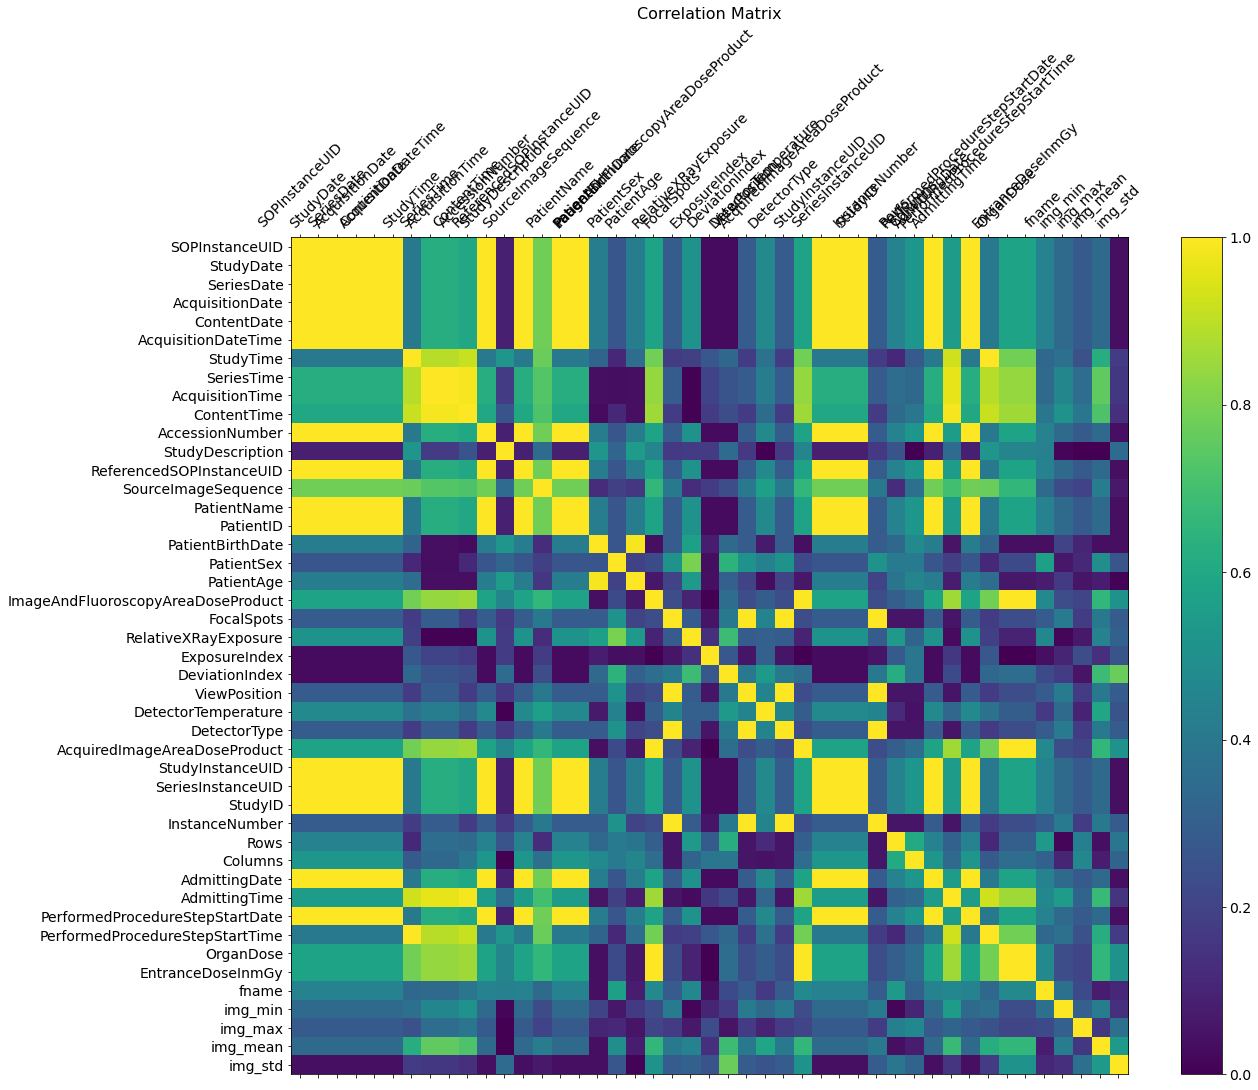

In [9]:
corr = df.astype('string').astype('category').apply(lambda x: x.cat.codes, axis=0).corr()

corr = corr.loc[corr.notnull().any(axis=0),corr.notnull().any(axis=1)].abs()

f = plt.figure(figsize=(19, 15))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(corr.shape[1]), corr.columns, fontsize=14, rotation=45)
plt.yticks(range(corr.shape[1]), corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.show()

The DeviationIndex seems to be a potential features related to the `img_mean` and `img_std`